# 1. File description 

To feed a model for it to predict a bot from a legit users I need the data to be labelled meaning each user in the dataset needs to have a 1 or 0 for bot/not bot. This file is meant to do so.

To label the data, multiple techniques are gonna be used and are divided in three. Manual, semi-manual and automatic labelling. 

Automatic: 
* Look at bot labelled and check for other users with the same photo. From previous iteration of the project, I have a folder with about 800 of bots photos that I previously found manually. Now, I just check if a user's profile pic is similar to any, if yes, it's a bot. That's the easiest way and the only one where I don't have to check other details of the bot as if two users have the same photo and one is a bot, the other is too.

Semi-manual:
* Look at the bots having a scam domain.
* Use NSFW pre-trained models to get images score for Neutral, Drawing, Hentai, Sexual, Porn and looking at the profile that have a high score for porn + sexy as most bots have nude photos
* Look at a subset of data where I belive bots are
    * Around 200 likes on their comment
    * 12 or less photos
    * Always have a link in their bio
* Find same/similar comments from labelled users 
* Pattern in Bio/description
* Look at the keyword of the flagged bots in comments and profile, look at profile that are similar to bots. 
* After labelling abunch of users, build a weak model to help in the labelling by making predictions. As long as the model is better than random, it'll be helpful.



## 0. Import module and setting notebook preferences

### 0.1 Import modules

In [159]:
# Load the data and display only the one from a 
query = '''
select 
    distinct 
    username
from clean_comments_users_last12
left join photos p using(username)
where 1=1
    and p.photo_type != 'summary'
'''
df_main = pd.read_sql_query(query, con)
df_main

,username
0,spencerp1017
1,vitamanb
2,mike222098
3,kaychanel__
4,amandagoodnite
...,...
86235,feelipepucci
86236,respectmypower
86237,taispowell
86238,kvngzuu


In [160]:
# # Load the data and display only the one from a 
# query = '''
# select 
#     *
# from photos
# where 1=1
# '''

# df_main = pd.read_sql_query(query, con)
# df_main.iloc[:467300].to_sql('photos', con, if_exists='replace', index=False)

In [161]:
query = '''
select 
    distinct
    username
from clean_comments_users_last12
where username not in (select username from photos where photo_type = 'summary')
'''
usernames = pd.read_sql_query(query, con)
# 'bleacherreport' in usernames
usernames

,username


In [162]:
import src.useful as su

import pandas as pd 
import numpy as np
import sqlite3 

import plotly.io as pio

# For image manipulation 
from PIL import Image, ImageDraw, ImageFont, UnidentifiedImageError

import os
import shutil

### 0.2 Notebook preferences

In [163]:
pd.set_option("display.max_columns", None)
pio.templates.default = "plotly_dark"

# Creating SQL database to store all the data for the project
database = "data/main_database.sqlite"
con = sqlite3.connect(database)

## 1. Manual labelling 

To label the data manually, the process has to be fast, I need to see all the information about the users condensed in one summary. For that, I chose to create for each user an image with their attributes and their photos. I'll then create a script to open one image by one, and then chose bot/not bot/maybe bot with keyboard arrows. 



In [164]:
# Load the data and display only the one from a 
query = '''
select 
    * 
from clean_comments_users_last12
'''

df_main = pd.read_sql_query(query, con)

### 1.1 Generate summary

I'm going to use the profile of a bot for the image demo. The account is still live but hasn't been active for about 9 months, at last the last comment on their post is. This is the developed function from [generate_summary.py](https://github.com/marclelamy/instagram_bot_classification/blob/main/3.1_generate_summary.py)

First, create a blank image, define font.

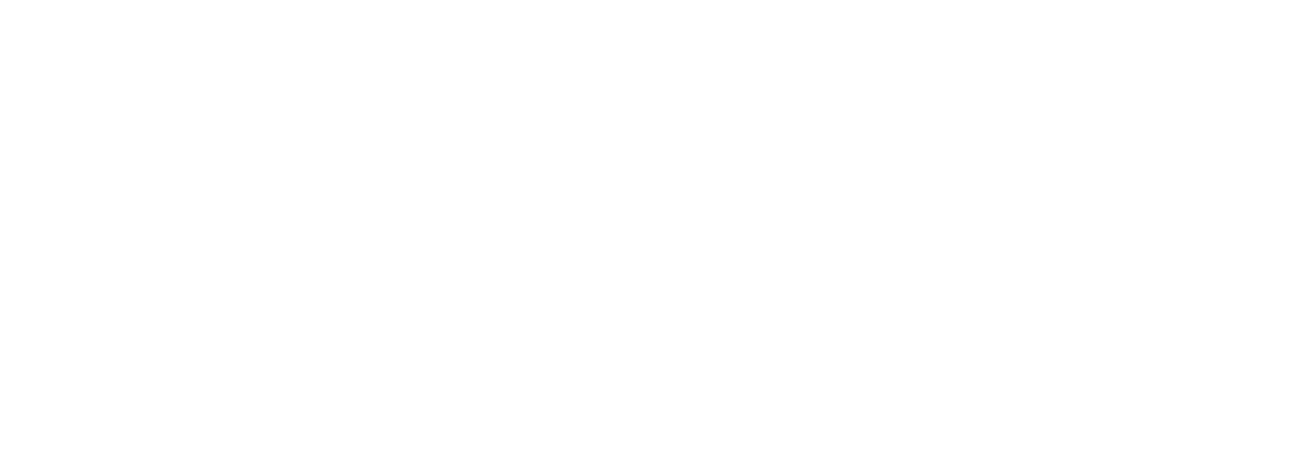

In [165]:
global_image = Image.new("RGB", (1300, 450), "white")
draw = ImageDraw.Draw(global_image)
font = ImageFont.truetype("OpenSans-Light.ttf", 15)

global_image

Add the profile picture 

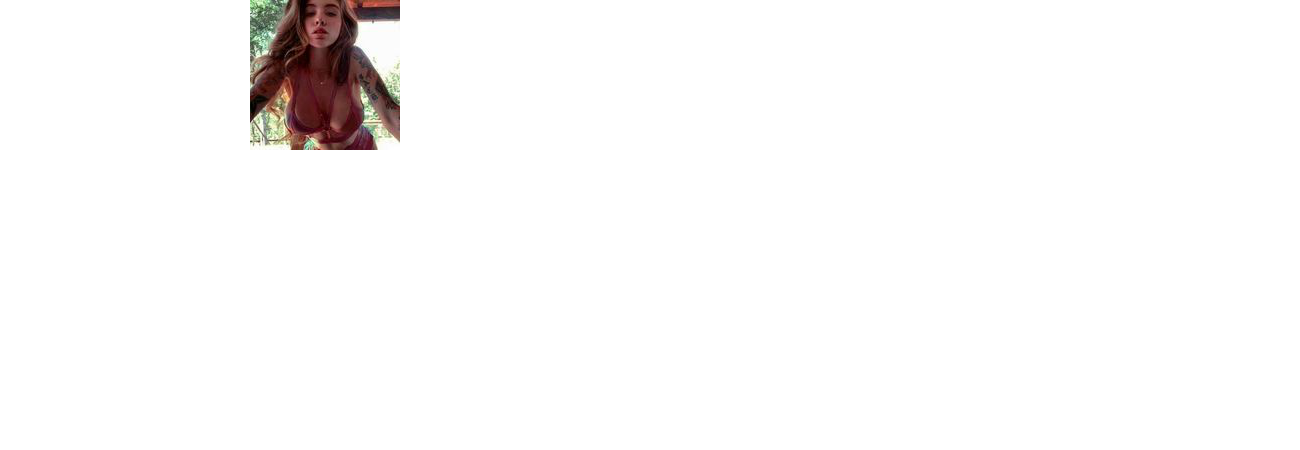

In [166]:
username = 'ulrikkeballi'
df_user = df_main[df_main["username"]==username].reset_index(drop=True)

# Open user pp and add it to the global image
try:
    path = f"data/photos/user_profile_pictures/{username}_pp_user_photo.png"
    profile_pic = Image.open(path)
    global_image.paste(profile_pic, (250, 0))
except (FileNotFoundError, UnidentifiedImageError): 
    pass

global_image

Adding twelve other photos 

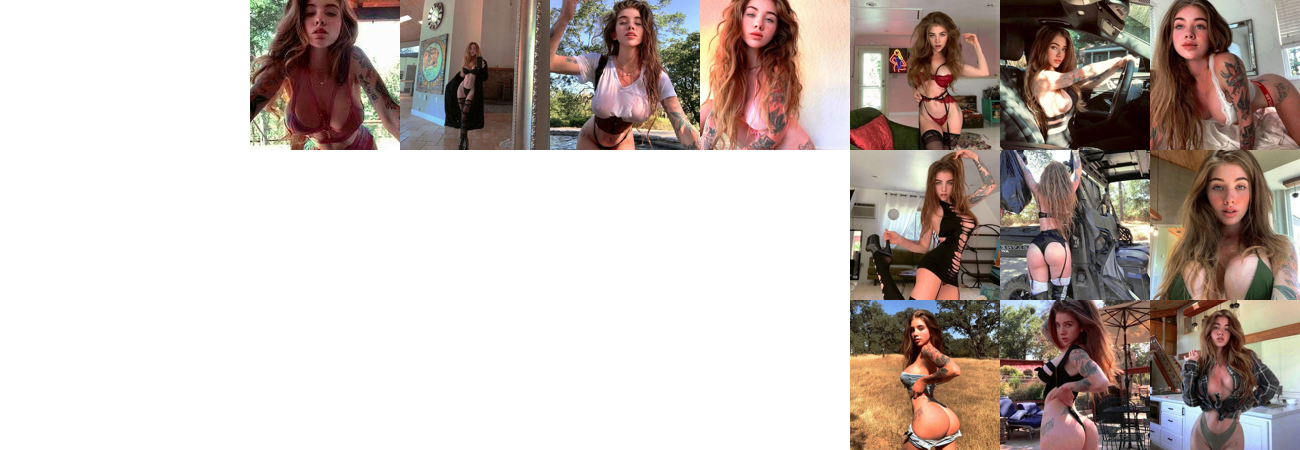

In [167]:
# Creating a list of position to add the photos on the global image
positions = []
for x in range(850, 1300, 150):
    for y in range(0, 450, 150):
        positions.append((x, y))


# Loop through each image and add it to the global image
for image_num in range(12):
    path = f"data/photos/user_last_12_posts/{username}_{str(image_num)}_user_photo.png"

    try:
        if os.path.exists(path):
            img = Image.open(path)
            if image_num < 9:
                global_image.paste(img.resize((150, 150)), positions[image_num])
            elif image_num == 9:
                global_image.paste(img.resize((150, 150)), (400, 0))
            elif image_num == 10:   
                global_image.paste(img.resize((150, 150)), (550, 0))
            elif image_num == 11:
                global_image.paste(img.resize((150, 150)), (700, 0))
    except (OSError, UnidentifiedImageError) as e: # For truncated image file
        pass

global_image

Adding screenshot of the landing page of the url in bio

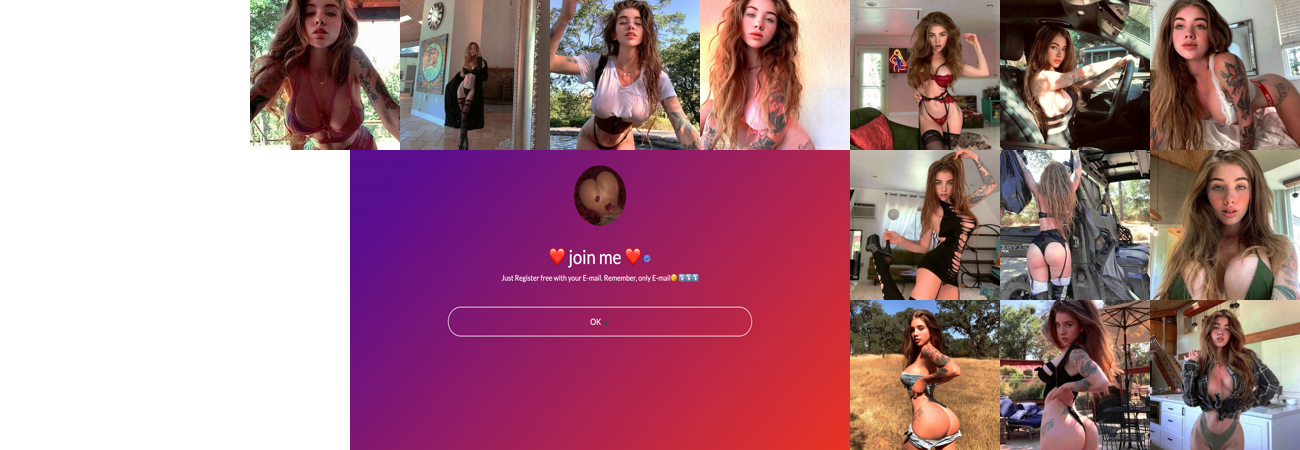

In [168]:
# Open screenshot, resize it, add it to global_image 
path = f"data/photos/bio_url_screenshot/{username}_website_photo.png"
try:
    screenshot = Image.open(path)
    global_image.paste(screenshot.resize((500, 300)), (350, 150))
except (UnidentifiedImageError, FileNotFoundError):
    pass

global_image

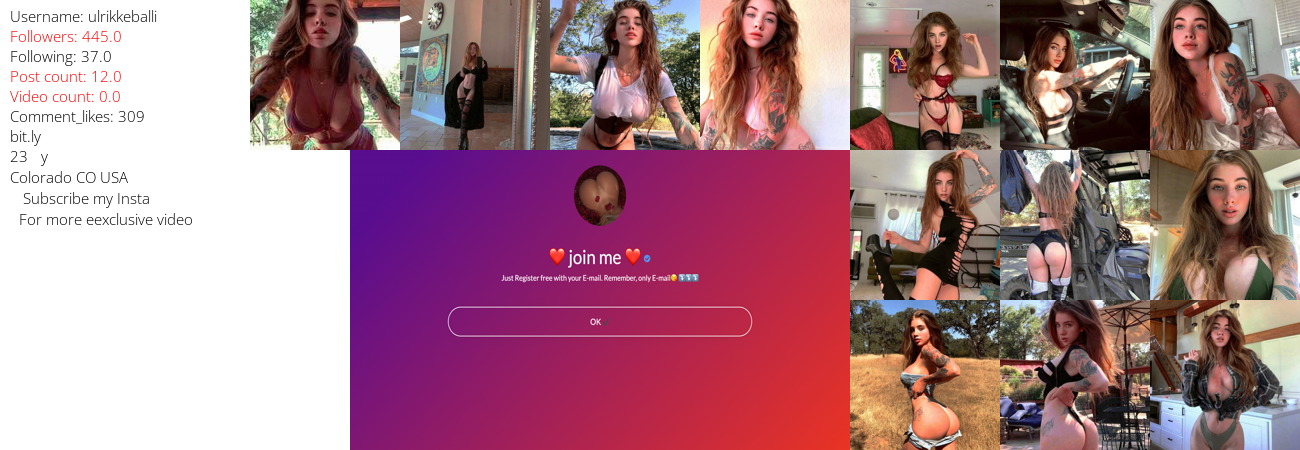

In [169]:
# Add basic information 
username = df_user.loc[0, "username"]
draw.text((10, 5), f"Username: {username}", font=font, fill="black")

follower_count = df_user.loc[0, "follower_count"]
color = "black" if follower_count > 800 else "red"
draw.text((10, 25), f"Followers: {follower_count:,}", font=font, fill=color)

follow_count = df_user.loc[0, "follow_count"]
draw.text((10, 45), f"Following: {follow_count:,}", font=font, fill="black")

post_count = df_user.loc[0, "post_count"]
color = "black" if post_count > 16 else "red"
draw.text((10, 65), f"Post count: {post_count}", font=font, fill=color)

video_count = df_user.loc[0, "video_count"]
color = "black" if video_count > 0 else "red"
draw.text((10, 85), f"Video count: {video_count}", font=font, fill=color)

comment_likes = round(df_user["comment_likes"].mean())
color = "black" if 200 <= comment_likes < 450 else "red"
draw.text((10, 105), f"Comment_likes: {comment_likes}", font=font, fill="black")

domain = df_user.loc[0, "domain"]
draw.text((10, 125), f"{domain}", font=font, fill="black")

biography = df_user.loc[0, "biography"]
draw.text((10, 145), f"{biography}", font=font, fill="black")


global_image

Save image

In [ ]:
# summary_path = f"data/photos/image_summary/{username}_image_summary.png"
# global_image.save(summary_path)

### 1.2 Manual labelling one by one

Look up for [3.2_manual_labelling.py](https://github.com/marclelamy/instagram_bot_classification/blob/main/3.2_manual_labelling.py)